In [25]:
import jax
from jax import numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from energax.sampling import buffers, continuous, discrete
from energax import nns, losses
from energax.ebms import nn_ebms
from nebula_plots import (
    get_nebula_score_field_plot_as_fig,
    get_nebula_energy_landscape_plot_as_fig,
    flatten_data,
    one_hot_to_int,
    get_score_fn_in_2d,
    get_energy_fn_in_2d,
)

import tensorflow_datasets as tfds
import numpy as np

# from tqdm.notebook import tqdm

In [30]:
# adapted from: https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html
data_dir = "/tmp/tfds"

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(
    name="mnist", batch_size=-1, data_dir=data_dir, with_info=True
)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data["train"], mnist_data["test"]
num_labels = info.features["label"].num_classes
h, w, c = info.features["image"].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data["image"], train_data["label"]

train_labels = jnp.array(train_labels).astype("int8")
# Full test set
test_images, test_labels = test_data["image"], test_data["label"]

test_labels = jnp.array(test_labels).astype("int8")

In [31]:
print("Train:", train_images.shape, train_labels.shape)
print("Test:", test_images.shape, test_labels.shape)

Train: (60000, 28, 28, 1) (60000,)
Test: (10000, 28, 28, 1) (10000,)


In [58]:
train_images = jnp.array(jnp.reshape(train_images,(train_images.shape[0], 28, 28)))
test_images = jnp.array(jnp.reshape(test_images,(test_images.shape[0], 28, 28)))

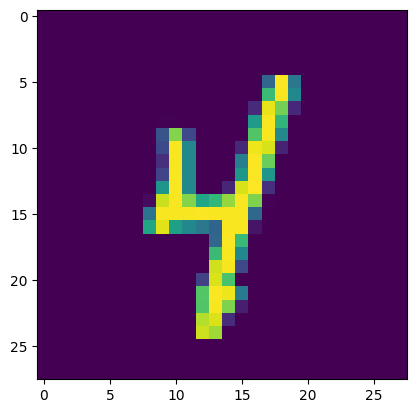

In [59]:
plt.imshow(train_images[0])

In [60]:
key = jax.random.PRNGKey(42)

In [61]:
batch_size = 128
key, subkey = jax.random.split(key)
replay_buffer = buffers.ContinuousReplayBuffer(
    (8192, 28, 28),
    minval=-1.0,
    maxval=1.0,
    num_chains=batch_size,
    ratio_new=0.05,
    key=subkey,
)
key, subkey = jax.random.split(key)
ebm = nn_ebms.ContinuousNNEBM(nns.MnistCNN(subkey))
loss_fn = lambda model, r, f: losses.contrastive_divergence(model, r, f, 0.1)
samp = continuous.LangevinSampler(
    (28, 28),
    num_chains=batch_size,
    minval=-1.0,
    maxval=1.0,
    stepsize=10.0,
    sigma=0.005,
    num_langevin_steps=60,
    sample_clip=1.0,
)

In [62]:
# nsteps = len(train_images) // batch_size * 10
nsteps = 2
data = 2 * jnp.array(train_images) - 1.0
max_images = len(data)
sample_fn = eqx.filter_jit(samp.sample_chains)

In [63]:
adam = optax.adam(1e-4)
optimizer = optax.chain(optax.clip_by_global_norm(0.1), adam)
opt_state = optimizer.init(eqx.filter(ebm, eqx.is_array))

In [64]:
value_and_grad_fct = eqx.filter_jit(eqx.filter_value_and_grad(loss_fn))


@eqx.filter_jit
def step(model, data_input, samples, opt_state):
    value, grads = value_and_grad_fct(model, data_input, samples)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, value, opt_state


@eqx.filter_jit
def inner_loop(model, buffer, opt_state, key):
    subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 4)
    buffer_samples = buffer.sample(subkey1)
    ebm_samples = sample_fn(model, buffer_samples, subkey2)["position"]
    buffer = buffers.update_buffer(buffer, ebm_samples)
    indices = jax.random.choice(
        subkey3, jnp.arange(max_images), shape=(batch_size,), replace=False
    )
    data_input = (
        jax.random.normal(subkey4, (batch_size, 28, 28)) * 0.005 + data[indices]
    )
    model, value, opt_state = step(model, data_input, ebm_samples, opt_state)
    return model, buffer, opt_state, value

In [65]:
loss = []

for j in range(nsteps):
    key, subkey = jax.random.split(key)
    ebm, replay_buffer, opt_state, value = inner_loop(
        ebm, replay_buffer, opt_state, subkey
    )
    loss.append(value)


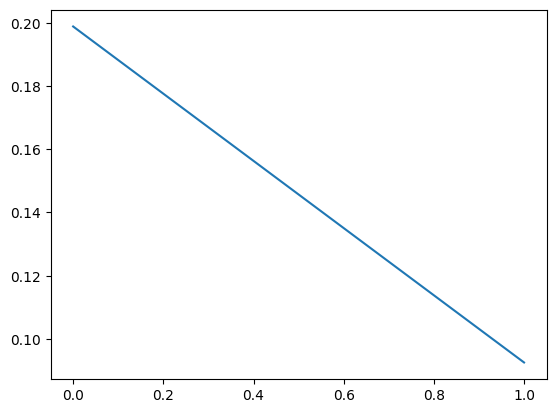

In [67]:
plt.plot(loss)
plt.show()

(4, 28, 28)


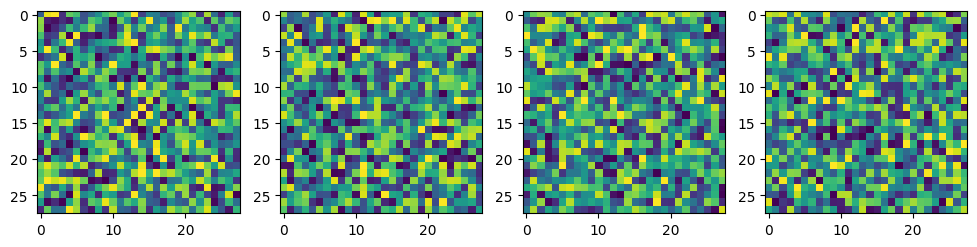

In [68]:
key, subkey = jax.random.split(key, 2)
inference_sampler = continuous.LangevinSampler(
    (28, 28),
    num_chains=4,
    minval=-1.0,
    maxval=1.0,
    stepsize=10.0,
    sigma=0.00,
    num_langevin_steps=260,
    sample_clip=1.0,
)
inference_fn = eqx.filter_jit(inference_sampler.sample_chains)
samples = inference_fn(ebm, None, subkey)["position"]
print(samples.shape)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(samples[i])

plt.show()

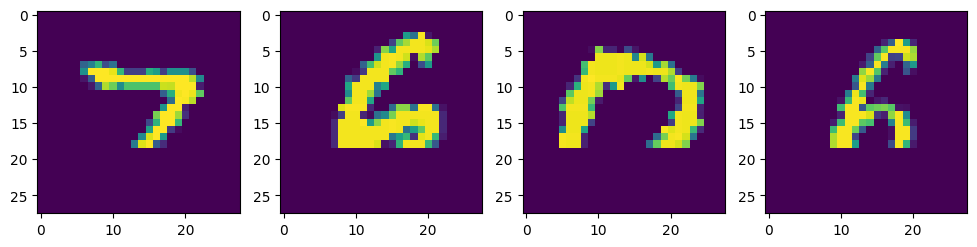

(4, 28, 28)


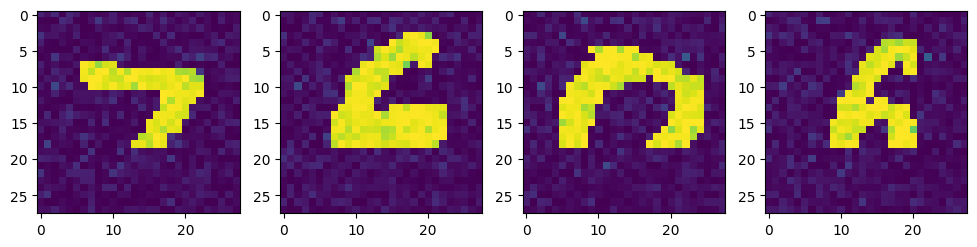

In [69]:
key, subkey = jax.random.split(key, 2)
comp_sampler = continuous.LangevinSampler(
    (28, 28),
    num_chains=4,
    minval=-1.0,
    maxval=1.0,
    stepsize=10.0,
    sigma=0.005,
    num_langevin_steps=300,
    sample_clip=1.0,
)
comp_fn = eqx.filter_jit(comp_sampler.sample_chains)
cutoffs = test_images[4:8].at[:, -9:, :].set(0) * 2 - 1.0
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(cutoffs[i])
plt.show()

samples = comp_fn(ebm, cutoffs, subkey)["position"]
print(samples.shape)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(samples[i])
plt.show()

# Out-of-distribution detection

One can use the energy outputs of an EBM to compare two distributions of inputs. The gap between energies can be significant given enough training and difference between the distributions. Let us see this on MNIST examples. 

1) Feeding random noise into images

Here, we just consider feeding random images by sampling uniformely pixel values. Note that the EBM requires values in the range \[-1,1\]. As you can witness below, the average energy score is much higher than when we find real test images. The score for images similar to the ones used during training should be very close to 0. 

In [70]:
key, subkey1, subkey2 = jax.random.split(key, 3)
ood_data = jax.random.uniform(subkey1, (1000, 28, 28)) * 2 - 1.0
in_data = test_images * 2 - 1.0
rand_out = jnp.mean(eqx.filter_vmap(ebm.energy_function)(ood_data))
test_out = jnp.mean(eqx.filter_vmap(ebm.energy_function)(in_data))
test_out_item = test_out.item()

In [71]:
print(f"Average score for random images: {rand_out.item():4.2f}")
print(f"Average score for test data: {test_out_item:4.2f}")

Average score for random images: -0.02
Average score for test data: -0.04


2) Adding random noise into images 

Instead of random pixels, this time we add random normal noise to the image pixel values (but truncating the values to \[-1,1\]). The resulting score is less higher than with random images, but still non-zero. 

In [72]:
ood_data = in_data + jax.random.normal(subkey1, test_images.shape) * 0.3
ood_data = jnp.clip(ood_data, -1.0, 1.0)

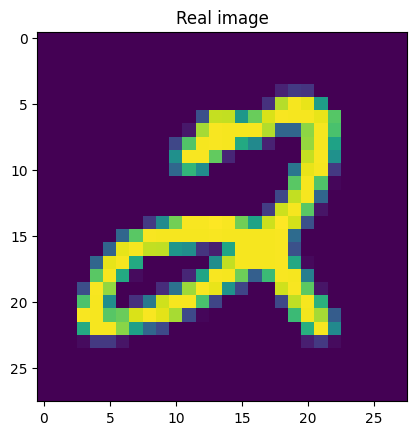

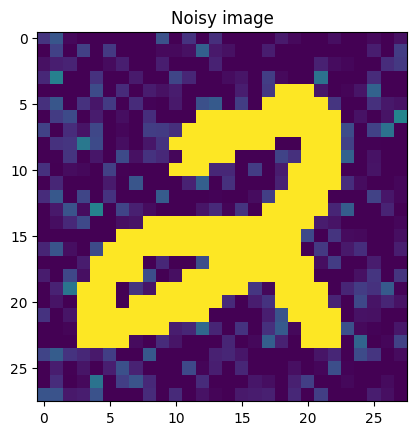

In [73]:
plt.imshow(test_images[0])
plt.title("Real image")
plt.show()
plt.imshow(ood_data[0])
plt.title("Noisy image")
plt.show()

In [74]:
rand_out = jnp.mean(eqx.filter_vmap(ebm.energy_function)(ood_data))
print(f"Average score for images with added random noise: {rand_out.item():4.2f}")
print(f"Average score for testing images: {test_out_item:4.2f}")

Average score for images with added random noise: -0.02
Average score for testing images: -0.04


3. Flipped images

Finally, we flip images and again compare scores. This time, the gap is very small, likely due to using a small CNN model. With a deeper model (but more difficult/expensive training), it may be possible to capture more characteristics of the digits to obtain better detection in such cases.

In [75]:
ood_data = jax.numpy.flip(in_data, (1, 2))

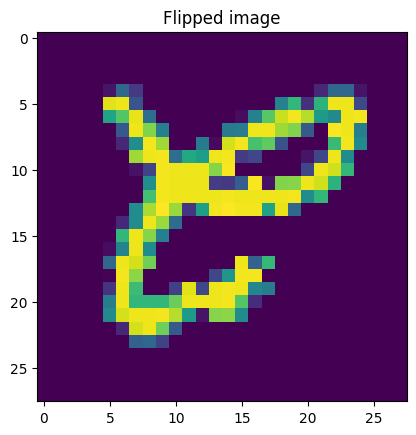

In [76]:
plt.imshow(ood_data[0])
plt.title("Flipped image")
plt.show()

In [77]:
rand_out = jnp.mean(eqx.filter_vmap(ebm.energy_function)(ood_data))
print(f"Average score for flipped images: {rand_out.item():4.2f}")
print(f"Average score for testing images: {test_out_item:4.2f}")

Average score for flipped images: -0.04
Average score for testing images: -0.04
